# Retrieval Models Expainability with Retrivex Tutorial

## Intallation

You need Python 3.9+ to run code in this tutorial. To install retrivex toolkit from sources run the following command:


In [ ]:
!pip install git+https://github.com/aikho/retrivex.git

## Explain Textual Similarity Prediction of SentenceTransformers Model with Integrated Jacobians Method

Load `SentenceTransformer` model and compute embedding similarity of two sentences:

In [2]:
from sentence_transformers import SentenceTransformer
sentences = [
    "Carbs are broken down into sugar in your body",
    "Carbohydrates are metabolized into glucose"
]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)

model.similarity(embeddings[0], embeddings[1])

tensor([[0.7136]])

These texts got 0.713 similarity score. Now let's explain this similarity score. 

First, load `SentenceTransformer` model to Integrated Jacobian explainer from `retrivex` toolkit.

This explainer is based on approach described in paper [Approximate Attributions for Off-the-Shelf Siamese Transformers (Moeller et al., EACL 2024)](https://aclanthology.org/2024.eacl-long.125/). 

In [3]:
from retrivex.stransformers import IntJacobianExplainableTransformer

explainer = IntJacobianExplainableTransformer("all-MiniLM-L6-v2")

No sentence-transformers model found with name sentence-transformers/all-MiniLM-L6-v2. Creating a new one with mean pooling.


Then generate token-to-token attribution matrix:

In [4]:
attributions, tokens1, tokens2, _ = explainer.explain(sentences[0], sentences[1])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 384/384 [00:10<00:00, 35.22it/s]


Now visualize attributions:

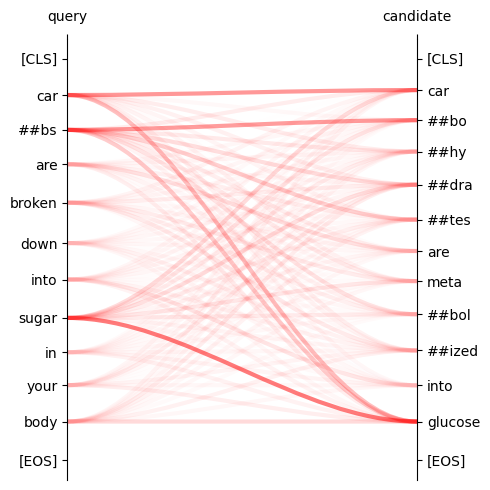

In [5]:
from retrivex.visualization import plot_connections
plot_connections(attributions, tokens1, tokens2)

Red indicates a positive contribution to the similarity score, while blue denotes a negative contribution. Higher color intensity corresponds to a greater magnitude of impact. 

The visualization appearance can be adjusted by configuring the function’s parameters.

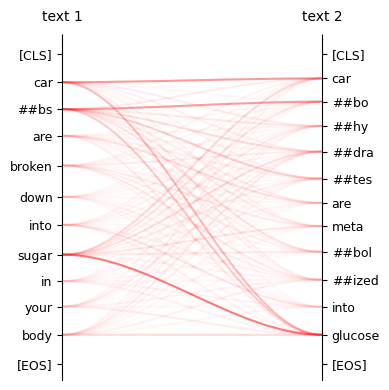

In [8]:
plot_connections(
    attributions, 
    tokens1, 
    tokens2,
    figsize=(4,4),
    query_label="text 1",
    candidate_label="text 2",
    token_fontsize=9,
    connection_line_thick=1.5,
    plot_pad= 0.05)

### Explaining of Predictions for Other SentenceTransformers Models and Usage of `explain()` Parameters"

For example, let's explain similarity prediction of popular embedding model for vector search `jina-embeddings-v2-base-en`. It requires to be loaded with `trust_remote_code=True`. Class `IntJacobianExplainableTransformer` extends the base `SentenceTransformer`. Thus, it supports the same ways of loading models as base `SentenceTransformer`.

Let's run explanation for `jinaai/jina-embeddings-v2-base-en`. Computing integrated gradients can be time-consuming. To improve efficiency we use fewer interpolation steps while still producing meaningful explanations. By default `250` interpolation steps are applied. You can reduce this number by adjusting the `num_interpolation_steps` parameter. Also, an excessively large number of interpolation steps can degrade the interpretability of the explanations.

No sentence-transformers model found with name jinaai/jina-embeddings-v2-base-en. Creating a new one with mean pooling.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:48<00:00, 15.76it/s]


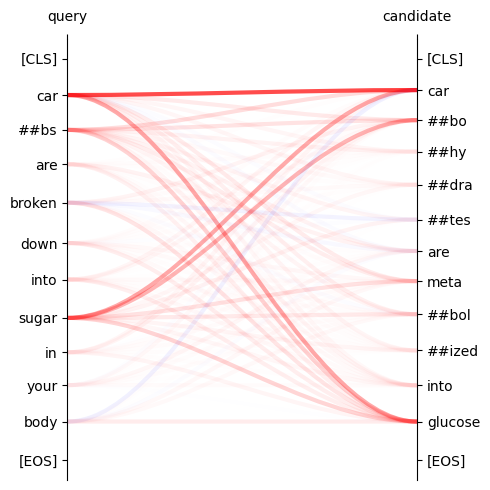

In [15]:
explainer = IntJacobianExplainableTransformer("jinaai/jina-embeddings-v2-base-en", trust_remote_code=True)

query = "Carbs are broken down into sugar in your body"
candidate = "Carbohydrates are metabolized into glucose"

attributions, query_tokens, candidate_tokens, details = explainer.explain(
    query, 
    candidate,
    num_interpolation_steps=50,
    return_details=True)

plot_connections(
    attributions,
    query_tokens=query_tokens, 
    candidate_tokens=candidate_tokens)

No sentence-transformers model found with name sentence-transformers/embeddinggemma-300m-medical. Creating a new one with mean pooling.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:50<00:00, 15.33it/s]


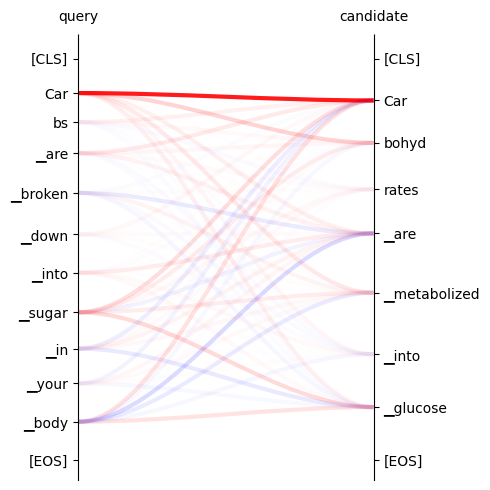

In [22]:
explainer = IntJacobianExplainableTransformer("embeddinggemma-300m-medical", trust_remote_code=True)

attributions, query_tokens, candidate_tokens, details = explainer.explain(
    query, 
    candidate,
    layer_index=0, 
    num_interpolation_steps=50,
    return_details=True)

plot_connections(
    attributions,
    query_tokens=query_tokens, 
    candidate_tokens=candidate_tokens)

If you set `return_details=True` then the output of `explain()` will include additional similarity terms.

In [23]:
details["query_candidate_similarity"]

0.9245126247406006

It is possible to speed up explanation generation at the expense of some quality of generated explanations by using intermediate encoder layer representations. This can be controlled through the `layer_index` parameter which defaults to `0`.

No sentence-transformers model found with name BAAI/bge-base-en-v1.5. Creating a new one with mean pooling.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:22<00:00, 33.48it/s]


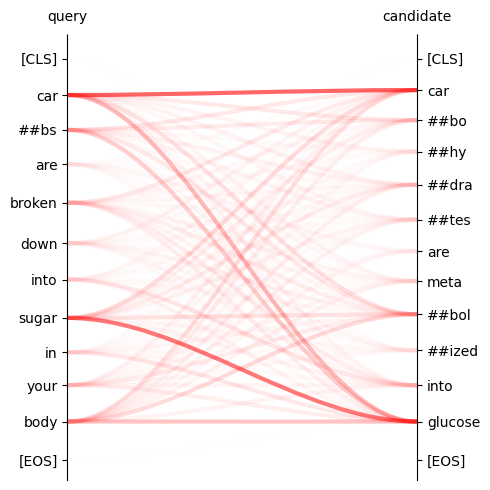

In [24]:
explainer = IntJacobianExplainableTransformer("BAAI/bge-base-en-v1.5", trust_remote_code=True)

attributions, query_tokens, candidate_tokens, details = explainer.explain(
    query, 
    candidate,
    layer_index=2, 
    num_interpolation_steps=50,
    return_details=True)

plot_connections(
    attributions,
    query_tokens=query_tokens, 
    candidate_tokens=candidate_tokens)

### Explainability for Your Custom SentenceTransformers Model

Class `IntJacobianExplainableTransformer` extends the base `SentenceTransformer`. Thus, it supports the same model loading methods as the base `SentenceTransformer`. You can load your custom fine-tuned model and call `explain()` to generate attibution matrix.

In [ ]:
explainer = IntJacobianExplainableTransformer("path/to/your/model")

attributions, query_tokens, candidate_tokens, details = explainer.explain(
    query, 
    candidate,
    layer_index=2, 
    num_interpolation_steps=50,
    return_details=True)

plot_connections(
    attributions,
    query_tokens=query_tokens, 
    candidate_tokens=candidate_tokens)